# PROYECTO 4 - MACHINE LEARNING

## Integrantes:
1. Marcelo
2. Alvaro
3. Adrian
4. 

---

# 1. Preparación y analisis de datos

In [4]:
# %pip install numpy
# %pip install matplotlib
%pip install scipy
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
# %pip install nltk
# %pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import torch
from torch.utils.data import DataLoader, TensorDataset

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import scipy
import gensim

np.random.seed(2024)

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.describe()

,message,label
count,25000,25000
unique,24904,2
top,How has this piece of crap stayed on TV this l...,neg
freq,3,12500


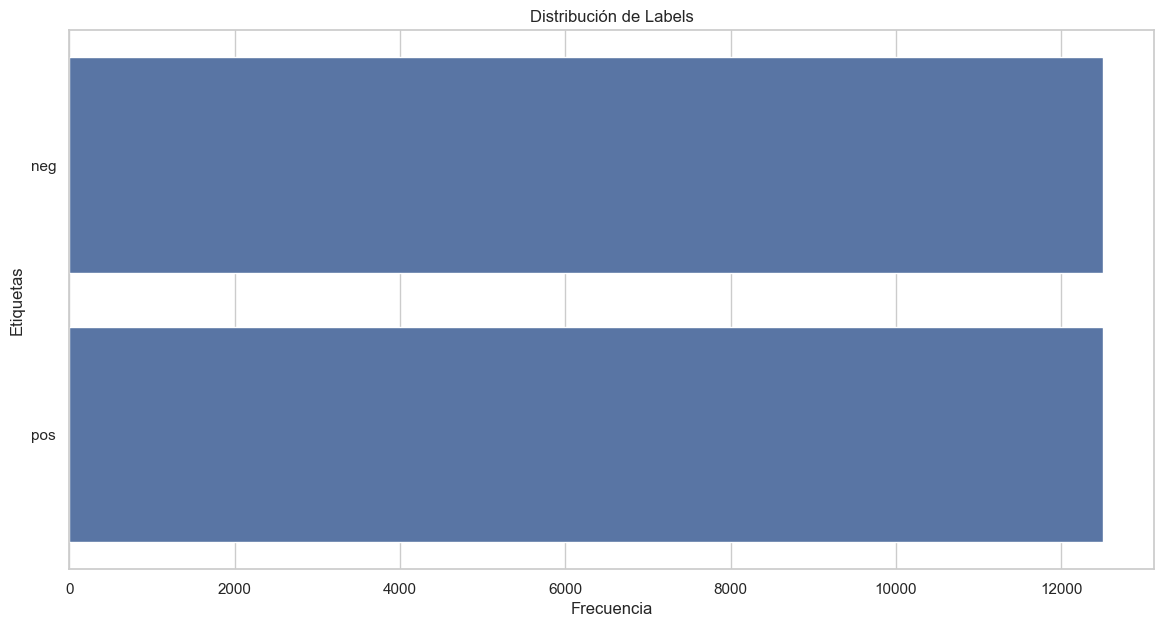

In [3]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.countplot(df_train.iloc[:, 1], order=df_train.iloc[:, 1].value_counts().index)

# Configurar los títulos y etiquetas
plt.title('Distribución de Labels')
plt.xlabel('Frecuencia')
plt.ylabel('Etiquetas')

# Mostrar la gráfica
plt.show()

----
# 2. Prepocesamiento

## TF-IDF

### Tokenizar, eliminar stopwords y Part-Of-Speech tag

In [29]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Lista de palabras de negación sintáctica
syntactic_negations = set(["no", "not", "none", "never", "neither", "nor", "cannot", "can't"])

# Lista de prefijos de negación morfológica
morphological_prefixes = ["un", "in", "dis", "im", "ir", "non", "anti"]

def tokenize(text):
    # return [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    return [word for word in word_tokenize(text.lower()) if word.isalpha()]

def pos_tagging(tokens):
    return pos_tag(tokens)

# Función para convertir etiquetas de POS de NLTK a etiquetas de WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def mark_negations(tokens):
    # Marca las palabras y frases con negaciones.
    negated_tokens = []
    negation = False
    for token in tokens:
        if token in syntactic_negations:
            negation = True
            negated_tokens.append(token)
        elif negation:
            if token in stop_words:
                negated_tokens.append(token)
            else:
                negated_tokens.append(token + "_NEG")
                negation = False
        else:
            negated_tokens.append(token)
    
    return negated_tokens

# def mark_negations(tokens):
#     negated_tokens = []
#     negation = False
#     for i, token in enumerate(tokens):
#         if token in syntactic_negations:
#             negation = True
#             negated_tokens.append(token)
#         elif negation:
#             if token in stop_words:
#                 negated_tokens.append(token)
#             else:
#                 negated_tokens.append(token + "_NEG")
#                 # Detectar doble negación
#                 if i > 0 and tokens[i - 1] == "not":
#                     negated_tokens[i] = tokens[i]
#                 negation = False
#         else:
#             negated_tokens.append(token)
    
#     return negated_tokens


def handle_morphological_negations(tokens):
    # Marca las palabras con prefijos de negación morfológica.
    negated_tokens = []
    for token in tokens:
        for prefix in morphological_prefixes:
            if token.startswith(prefix):
                root = token[len(prefix):]
                negated_tokens.append(root + "_NEG")
                break
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def handle_double_negations(tokens):
    negated_tokens = []
    for i, token in enumerate(tokens):
        if token.endswith("_NEG_NEG"):
            negated_tokens.append(token[:-8])
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def lemmatize(pos_tags):
    return [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos) or wordnet.NOUN) for word, pos in pos_tags]

def preprocess(df):
    df['tokens'] = df['message'].apply(tokenize)
    df['tokens'] = df['tokens'].apply(mark_negations)
    df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    df['tokens'] = df['tokens'].apply(handle_morphological_negations)
    df['tokens'] = df['tokens'].apply(handle_double_negations)
    df['pos_tags'] = df['tokens'].apply(pos_tagging)
    df['lemmas'] = df['pos_tags'].apply(lemmatize)
    return df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
# Ejemplo de uso
import pandas as pd

data = {'message': ["The audience disliked the actor leading the play.", 
                    "He was not supposed to come.", 
                    "The price of the car is not insignificant."]}

df = pd.DataFrame(data)
processed_df = preprocess(df)

processed_df[['message', 'tokens', 'lemmas']]

,message,tokens,lemmas
0,The audience disliked the actor leading the play.,"[audience, liked_NEG, actor, leading, play]","[audience, liked_NEG, actor, lead, play]"
1,He was not supposed to come.,"[supposed_NEG, come]","[supposed_NEG, come]"
2,The price of the car is not insignificant.,"[price, car, significant]","[price, car, significant]"


In [31]:
df_train_tf = preprocess(df_train)
df_submit_tf = preprocess(df_test)
df_train_tf.to_pickle('df_train_processed.pkl')
df_submit_tf.to_pickle('df_test_processed.pkl')

### Cargar data una vez preprocesada

In [8]:
df_train_tf = pd.read_pickle('df_train_processed.pkl')
df_submit = pd.read_pickle('df_test_processed.pkl')

In [32]:
from sklearn.model_selection import train_test_split
df_train_tf, df_test_tf = train_test_split(df_train, test_size=0.2, random_state=2024)

In [33]:
# use tf-idf to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=1000)
tfidf = TfidfVectorizer()

x_train = tfidf.fit_transform(df_train_tf['lemmas'].apply(' '.join))
x_test = tfidf.transform(df_test_tf['lemmas'].apply(' '.join))
x_submit = tfidf.transform(df_submit['lemmas'].apply(' '.join))

In [34]:
#enconde de y a valores numericos
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['label'])
y_test = label_encoder.transform(df_test['label'])


#verificar que significa cada valor numerico
label_encoder.classes_

array(['neg', 'pos'], dtype=object)

In [35]:
from sklearn.feature_selection import SelectKBest, chi2

k = 1000  # Número de características a seleccionar, ajusta este valor según sea necesario
chi2_selector = SelectKBest(chi2, k=k)
x_train_chi2 = chi2_selector.fit_transform(x_train, y_train)
x_test_chi2 = chi2_selector.transform(x_test)
x_submit_chi2 = chi2_selector.transform(x_submit)

In [36]:
n_features = x_train_chi2.shape[1]
print(f'Number of features: {n_features}')

Number of features: 1000


## Character quantization

### Analisis de datos

Promedio de longitud de mensajes: 1325.06964


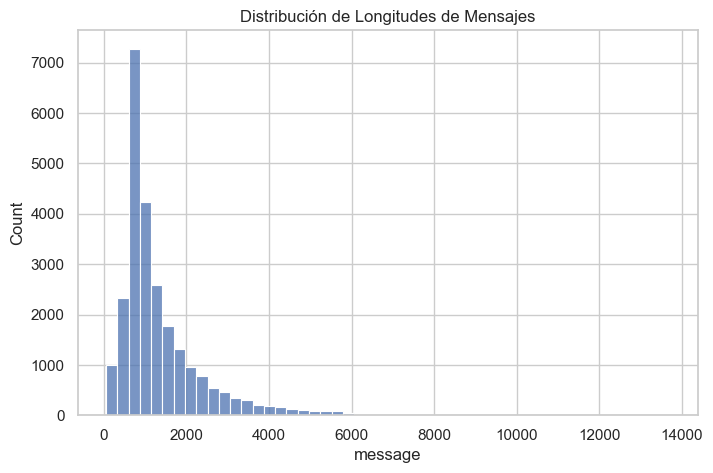

In [4]:
#graficar distribución de las longitudes de los mensajes
plt.figure(figsize=(8, 5))
sns.histplot(df_train['message'].apply(len), bins=50)
#set title
plt.title('Distribución de Longitudes de Mensajes')

prom_len = df_train['message'].apply(len).mean()
print(f'Promedio de longitud de mensajes: {prom_len}')


Text(0, 0.5, 'Frecuencia')

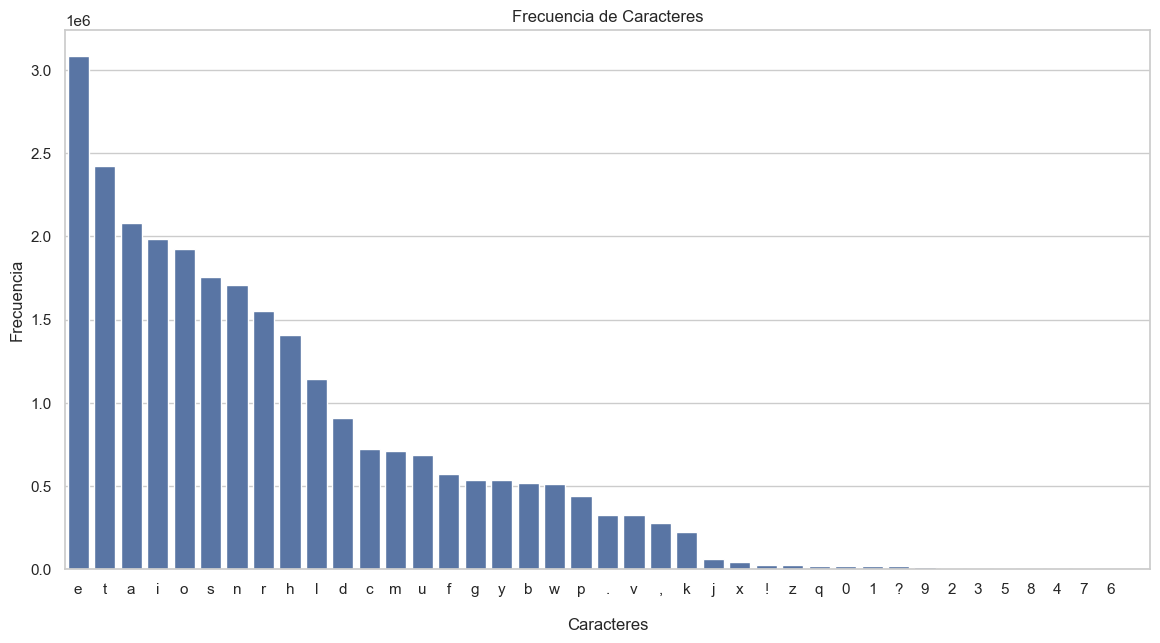

In [5]:
#graficar la frecuencia de cada caracter
dict_chars = { c : 0 for c in 'abcdefghijklmnopqrstuvwxyz!?.,0123456789\n'}
for message in df_train['message']:
    for c in message.lower():
        if c in dict_chars:
            dict_chars[c] += 1
            
            
#Oderdar de mayor a menor frecuencia
dict_chars = dict(sorted(dict_chars.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(14, 7))
sns.barplot(x=list(dict_chars.keys()), y=list(dict_chars.values()))
plt.title('Frecuencia de Caracteres')
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')


In [6]:
#seleccionar los primeros k caracteres mas frecuentes
k = 28
alfabet_used = list(dict_chars.keys())[0:k]
print(f'Caracteres más frecuentes usados: {alfabet_used}')

Caracteres más frecuentes usados: ['e', 't', 'a', 'i', 'o', 's', 'n', 'r', 'h', 'l', 'd', 'c', 'm', 'u', 'f', 'g', 'y', 'b', 'w', 'p', '.', 'v', ',', 'k', 'j', 'x', '!', 'z']


### Extracción

In [7]:
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix


# Funciones auxiliares
def build_char_mat(quote, MAX_LEN, CHAR_DICT):
    # Usamos lil_matrix para la matriz dispersa
    char_mat = np.zeros((len(CHAR_DICT), MAX_LEN), dtype=np.float32)
    quote = quote.lower()
    for i, char in enumerate(quote):
        if i >= MAX_LEN:
            break
        if char in CHAR_DICT:
            char_mat[CHAR_DICT[char], i] = 1
    return char_mat

def generate_char_dict(string):
    char_dict = {}
    for char in string:
        if char not in char_dict:
            char_dict[char] = len(char_dict)
    return char_dict

def executeCQ(df, alfabet, MAX_LEN):
    CHAR_DICT = generate_char_dict(alfabet)
    results = []
    for row in df:
        # Remove special characters that are not in the alphabet
        msg = ''.join([char for char in row if char in CHAR_DICT])
        char_mat = torch.tensor(build_char_mat(msg, MAX_LEN, CHAR_DICT))
        results.append(char_mat)
    return torch.stack(results, dim=0)

In [8]:
from sklearn.model_selection import train_test_split
df_train_cq, df_test_cq = train_test_split(df_train, test_size=0.15, random_state=2024)
alfabet_dict = generate_char_dict(alfabet_used)

In [9]:
x_train_cq = executeCQ(df_train_cq['message'], alfabet_used, 4500)
x_test_cq = executeCQ(df_test_cq['message'], alfabet_used, 4500)
n_features = x_train_cq.shape[2]
n_chars = x_train_cq.shape[1]
print(f'Number of features: {n_features}')
print(f'Number of characters: {n_chars}')

Number of features: 4500
Number of characters: 28


In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_cq = label_encoder.fit_transform(df_train_cq['label'])
y_test_cq = label_encoder.transform(df_test_cq['label'])

## WORD2VEC

In [176]:
import torch
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
alphabet_used = set("abcdefghijklmnopqrstuvwxyz ")


def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char in alphabet_used])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

def build_df_words(df):
    #add new column
    d = df.copy()
    d['words'] = d['message'].apply(preprocess_text)
    return d

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [177]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_train_words, df_test_words = train_test_split(df_train, test_size=0.20, random_state=1993)

df_train_words = build_df_words(df_train_words)
df_test_words = build_df_words(df_test_words)

In [178]:
#realizar conteo de vocabulario
vocab = set()
for words in df_train_words['words']:
    vocab.update(words)

print(f'Vocabulario: {len(vocab)} palabras')

Vocabulario: 104691 palabras


### Cargar modelo preentrenado

In [179]:
#load numpy
import gensim.downloader as api

#load word2vec
word2vec = api.load('word2vec-google-news-300')

### Extraer vectores

In [180]:
#construir matrix
def build_embedding_matrix(df, word2vec_dict, max_words):
    result = []
    for words in df['words']:
        emb = np.zeros((300))
        count = 0
        for word in words:
            count += 1
            if word in word2vec_dict:
                emb += word2vec_dict[word]
        result.append(emb / count)
    return np.stack(result, axis=0)

In [181]:
x_train_wd = build_embedding_matrix(df_train_words, word2vec, 2**64)
x_test_wd = build_embedding_matrix(df_test_words, word2vec, 2**64)

n_features = x_train_wd.shape[1]
print(f'Number of features: {n_features}')

Number of features: 300


In [142]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_wd = label_encoder.fit_transform(df_train_words['label'])
y_test_wd = label_encoder.transform(df_test_words['label'])

----
# 3. Experimentación

In [85]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [86]:
#funciones de experimentación
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def matriz_confusion(y_test, y_pred, Tipo):
 matrix = confusion_matrix(y_test, y_pred)
 f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index= label_encoder.classes_  , columns=label_encoder.classes_)
 sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
 plt.title("Confusion Matrix - "  + Tipo ), plt.tight_layout()
 plt.xlabel("Predicted")
 plt.ylabel("Real")
 plt.show()

# Write your code here
def test(model, loader, tipo):
  if tipo == "MLP" or tipo == "CNN":
    model.eval()
    #crear tensores de salida
    y_test = torch.tensor([], dtype=torch.long)
    y_pred = torch.tensor([], dtype=torch.long)
    with torch.no_grad():
        for x_test_v, y_test_v in loader:
          x_test_v = x_test_v.to(device)
          y_test_v = y_test_v.to(device)
          y_pred_v = model(x_test_v)
    
          y_pred_v = torch.argmax(y_pred_v, dim=1).cpu()
          y_test_v = y_test_v.cpu()
          
          #agregar a las listas
          y_test = torch.cat((y_test, y_test_v), dim=0)
          y_pred = torch.cat((y_pred, y_pred_v), dim=0)
        torch.cuda.empty_cache()
  else:
    y_pred = model.predict(x_test)
    
  print("F",y_test)
  print("F",y_pred)

    
  print(classification_report(y_test, y_pred))
  matriz_confusion(y_test, y_pred,tipo)

## SVM TEST

In [13]:
# fast test with training with svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

## Neural Networks TEST

### Funciones auxiliares

In [64]:
def train(model, loss_f, optimizer, epochs, train_loader,name):
    loss_lista = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            loss = loss_f(y_pred, y_batch)
            epoch_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_lista.append(avg_epoch_loss)
        torch.save(model.state_dict(), f"models/{name}.pth")
        if epoch % 1 == 0:
            print('Epoch {}: train loss: {:.4f}'.format(epoch, avg_epoch_loss))
    return loss_lista

### MLP TEST

In [143]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Arquitectura

In [144]:
#MLP
import torch.nn as nn

#0.84
# INPUT_SIZE = 1000
# OUTPUT_SIZE = 2
# LAYERS = 2
# LAYER_SIZE = 1000

INPUT_SIZE = n_features
OUTPUT_SIZE = 2
LAYERS = 10
LAYER_SIZE = 100
DROPOUT_RATE = 0.5
BATCH_SIZE = 64


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        # Primera capa
        self.layers.append(nn.Linear(INPUT_SIZE, LAYER_SIZE))
        self.layers.append(nn.BatchNorm1d(LAYER_SIZE))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(DROPOUT_RATE))

        # Capas intermedias
        for _ in range(LAYERS):
            self.layers.append(nn.Linear(LAYER_SIZE, LAYER_SIZE))
            self.layers.append(nn.BatchNorm1d(LAYER_SIZE))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(DROPOUT_RATE))

        # Última capa
        self.layers.append(nn.Linear(LAYER_SIZE, OUTPUT_SIZE))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [167]:
from torch import nn
INPUT_SIZE = n_features
OUTPUT_SIZE = 2
BATCH_SIZE = 32
LAYER_SIZE = 400

#0.86 accuracy
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        # Primera capa
        self.layer1 = nn.Sequential(
            nn.Linear(INPUT_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(LAYER_SIZE, OUTPUT_SIZE)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [171]:
from torch import nn
INPUT_SIZE = n_features
OUTPUT_SIZE = 2
BATCH_SIZE = 16
LAYER_SIZE = 385

#
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        # Primera capa
        self.layer1 = nn.Sequential(
            nn.Linear(INPUT_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(LAYER_SIZE, LAYER_SIZE),
            nn.BatchNorm1d(LAYER_SIZE),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(LAYER_SIZE, OUTPUT_SIZE)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

#### Entrenamiento

In [172]:
import torch
# Modelos
model = MLP().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0075, weight_decay=1e-5)

##### TEST 1 (TFIDF)

In [ ]:
# x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
x_train_dv = torch.tensor(x_train_chi2.toarray(), dtype=torch.float32)
y_train_dv = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("MLP TRAIN - TFIDF")
loss_list = train(model, loss, optimizer, 10, train_loader,"MLP_TDIF")

##### TEST 2 (WORD2VEC)

In [173]:
x_train_dv = torch.tensor(x_train_wd, dtype=torch.float32)
y_train_dv = torch.tensor(y_train_wd, dtype=torch.long)

train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("MLP TRAIN - WORD2VEC")
loss_list = train(model, loss, optimizer, 30, train_loader,"MLP_W2V_B")

MLP TRAIN - WORD2VEC
Epoch 0: train loss: 0.4589
Epoch 1: train loss: 0.4072
Epoch 2: train loss: 0.3928
Epoch 3: train loss: 0.3901
Epoch 4: train loss: 0.3881
Epoch 5: train loss: 0.3778
Epoch 6: train loss: 0.3748
Epoch 7: train loss: 0.3712
Epoch 8: train loss: 0.3665
Epoch 9: train loss: 0.3606
Epoch 10: train loss: 0.3561
Epoch 11: train loss: 0.3510
Epoch 12: train loss: 0.3476
Epoch 13: train loss: 0.3426
Epoch 14: train loss: 0.3368
Epoch 15: train loss: 0.3303
Epoch 16: train loss: 0.3332
Epoch 17: train loss: 0.3229
Epoch 18: train loss: 0.3185
Epoch 19: train loss: 0.3193
Epoch 20: train loss: 0.3096
Epoch 21: train loss: 0.3142
Epoch 22: train loss: 0.3088
Epoch 23: train loss: 0.3047
Epoch 24: train loss: 0.3039
Epoch 25: train loss: 0.2955
Epoch 26: train loss: 0.2952
Epoch 27: train loss: 0.2937
Epoch 28: train loss: 0.2961
Epoch 29: train loss: 0.2885


#### Resultados

In [ ]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
#Test 
x_test_dv = torch.tensor(x_test_chi2.toarray(), dtype=torch.float32)
y_test_dv = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, "MLP")

F tensor([1, 1, 1,  ..., 1, 1, 0])
F tensor([1, 1, 1,  ..., 1, 1, 0])
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1841
           1       0.82      0.91      0.86      1909

    accuracy                           0.85      3750
   macro avg       0.86      0.85      0.85      3750
weighted avg       0.86      0.85      0.85      3750



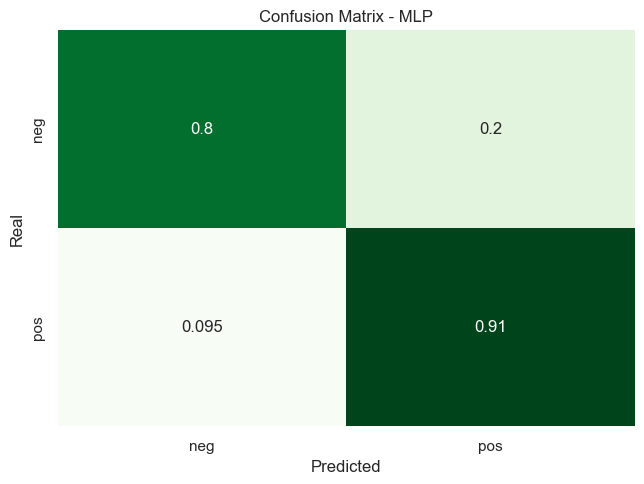

In [175]:
x_test_dv = torch.tensor(x_test_wd, dtype=torch.float32)
y_test_dv = torch.tensor(y_test_wd, dtype=torch.long)

test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, "MLP")

In [213]:
#Exportar datos a csv
x_submit_t = torch.tensor(x_submit_chi2.toarray(), dtype=torch.float32)
submit_dataset = TensorDataset(x_submit_t)
submit_loader = DataLoader(submit_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
model.eval()
with torch.no_grad():
    for batch in submit_loader:
        batch = batch[0].to(device)
        pred = model(batch)
        pred = torch.argmax(pred, dim=1).cpu()
        all_preds.extend(pred)

label_map = {0: 'neg', 1: 'pos'}
labels = [label_map[label.item()] for label in all_preds]

ids = list(range(len(labels)))
submission_df = pd.DataFrame({'ids': ids, 'label': labels})

submission_df.to_csv('submit.csv', index=False)

### CNN TEST

In [43]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Arquitectura

In [22]:
#CNN
import torch.nn as nn

QUOTE_SIZE = n_features
#ALFABET_SIZE = n_chars
OUTPUT_SIZE = 2
DROPOUT_RATE = 0.4
BATCH_SIZE = 32

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layerConv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3),
            
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3),
            )
    
        #obtain the size of the output of the convolutional layers
        output_size = self.layerConv(torch.rand(1, 1, QUOTE_SIZE)).size()
        layerFC_input = output_size[1] * output_size[2]
        
        self.layerFC = nn.Sequential(
            nn.Linear(layerFC_input, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(1024, OUTPUT_SIZE))
        
    def forward(self, x):
        #print(x.size())
        out = self.layerConv(x)
        #print(out.size())
        out = out.reshape(out.size(0), -1)
        #print(out.size())
        out = self.layerFC(out)
        return out

#### Entrenamiento

In [23]:
# Modelos
modelCNN = CNN().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(modelCNN.parameters(), lr = 0.01)

In [20]:
#cargar si existe
modelCNN = CNN().to(device)
modelCNN.load_state_dict(torch.load('modelCNN.pth'))
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(modelCNN.parameters(), lr = 0.005,weight_decay=1e-5)

In [25]:
x_train_dv = torch.tensor(x_train_chi2.todense(), dtype=torch.float32)
x_train_dv = x_train_dv.reshape(-1, 1, QUOTE_SIZE)

y_train_dv = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("CNN TRAIN")
loss_list = train(modelCNN, loss, optimizer, 10, train_loader,"modelCNN")

CNN TRAIN
Epoch 0: train loss: 0.4986
Epoch 1: train loss: 0.3146
Epoch 2: train loss: 0.2384
Epoch 3: train loss: 0.1811
Epoch 4: train loss: 0.1357
Epoch 5: train loss: 0.1175
Epoch 6: train loss: 0.1036
Epoch 7: train loss: 0.0927
Epoch 8: train loss: 0.0983
Epoch 9: train loss: 0.0846


In [48]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
x_train_dv = x_train_cq
#x_train_dv = x_train_dv.reshape(-1, 1, x_train_cq[0].shape[0], x_train_cq[0].shape[1])

print(x_train_dv.shape)
y_train_dv = torch.tensor(y_train_cq, dtype=torch.long)

train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("CNN TRAIN")
loss_list = train(modelCNN, loss, optimizer, 10, train_loader,"modelCNN_RT")

torch.Size([21250, 28, 4500])
CNN TRAIN
Epoch 0: train loss: 0.9140
Epoch 1: train loss: 0.6663
Epoch 2: train loss: 0.4657
Epoch 3: train loss: 0.3885
Epoch 4: train loss: 0.3401
Epoch 5: train loss: 0.2937
Epoch 6: train loss: 0.2477
Epoch 7: train loss: 0.2107
Epoch 8: train loss: 0.1875
Epoch 9: train loss: 0.1599


In [97]:
del x_train_dv

#### Resultados

torch.Size([20000, 1, 7000])
F tensor([1, 0, 0,  ..., 0, 0, 1])
F tensor([1, 1, 1,  ..., 1, 1, 1])
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     10037
           1       0.50      1.00      0.67      9963

    accuracy                           0.50     20000
   macro avg       0.75      0.50      0.33     20000
weighted avg       0.75      0.50      0.33     20000



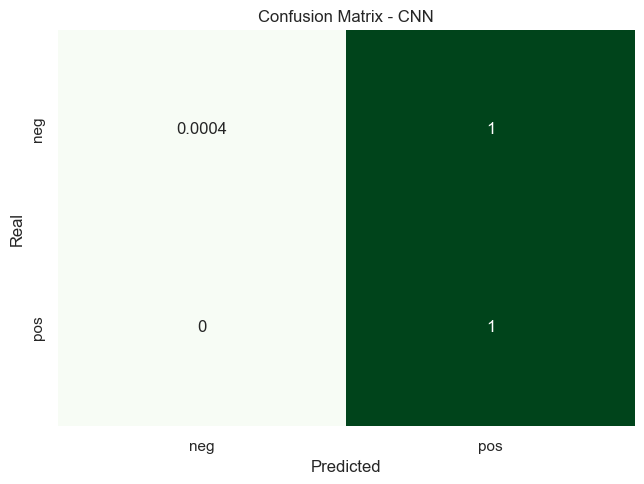

In [28]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
x_test_dv = torch.tensor(x_train_chi2.todense(), dtype=torch.float32)
x_test_dv = x_test_dv.reshape(-1, 1, n_features)
print(x_test_dv.shape)

y_test_dv = torch.tensor(y_train, dtype=torch.long)
test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(modelCNN, test_loader, "CNN")

In [26]:
#Exportar datos a csv
x_submit_t = torch.tensor(x_submit_chi2.toarray(), dtype=torch.float32)
x_submit_t = x_submit_t.reshape(-1, 1, n_features)
submit_dataset = TensorDataset(x_submit_t)
submit_loader = DataLoader(submit_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
modelCNN.eval()
with torch.no_grad():
    for batch in submit_loader:
        batch = batch[0].to(device)
        pred = modelCNN(batch)
        pred = torch.argmax(pred, dim=1).cpu()
        all_preds.extend(pred)

label_map = {0: 'neg', 1: 'pos'}
labels = [label_map[label.item()] for label in all_preds]

ids = list(range(len(labels)))
submission_df = pd.DataFrame({'ids': ids, 'label': labels})

submission_df.to_csv('submit.csv', index=False)

----
# MISC



In [18]:
#clear memory
import gc
import torch

gc.collect()            # Llama al recolector de basura para liberar memoria
torch.cuda.empty_cache()  # Limpia la memoria de GPU

In [19]:
#delete all variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
        
del name